In [1]:
import pandas as pd
import string
import re
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier


In [2]:
products = pd.read_csv('amazon_baby_subset.csv')

In [3]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53072 entries, 0 to 53071
Data columns (total 4 columns):
name         52982 non-null object
review       52831 non-null object
rating       53072 non-null int64
sentiment    53072 non-null int64
dtypes: int64(2), object(2)
memory usage: 1.6+ MB


In [4]:
important_words = pd.read_json('important_words.json')

In [5]:
important_words.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 1 columns):
0    193 non-null object
dtypes: object(1)
memory usage: 1.6+ KB


In [6]:
products.name[0:10]

0    Stop Pacifier Sucking without tears with Thumb...
1      Nature's Lullabies Second Year Sticker Calendar
2      Nature's Lullabies Second Year Sticker Calendar
3                          Lamaze Peekaboo, I Love You
4    SoftPlay Peek-A-Boo Where's Elmo A Children's ...
5                            Our Baby Girl Memory Book
6    Hunnt&reg; Falling Flowers and Birds Kids Nurs...
7    Blessed By Pope Benedict XVI Divine Mercy Full...
8    Cloth Diaper Pins Stainless Steel Traditional ...
9    Cloth Diaper Pins Stainless Steel Traditional ...
Name: name, dtype: object

In [7]:
products.review[products.sentiment==1].count()

26438

In [8]:
products.review[products.sentiment==-1].count()

26393

In [9]:
products.review.isna().sum()

241

In [10]:
products['review'] = products.review.fillna('')

In [11]:
products.review.isna().sum()

0

In [12]:
def remove_punctuation(text):
    return re.sub(r'[^\w\s]','',text) 

In [13]:
products['review_clean'] = products.review.apply(lambda x: remove_punctuation(x))

In [14]:
important_words = important_words[0].tolist()
for word in important_words:
    products[word] = products['review_clean'].apply(lambda s : s.split().count(word))

In [15]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53072 entries, 0 to 53071
Columns: 198 entries, name to either
dtypes: int64(195), object(3)
memory usage: 80.2+ MB


In [16]:
products.sample(5)

,name,review,rating,sentiment,review_clean,baby,one,great,love,use,...,seems,picture,completely,wish,buying,babies,won,tub,almost,either
18009,Bummis Easy Fit Tots Bots One Size Cloth Diape...,We've been using easy fits on our daughter for...,5,1,Weve been using easy fits on our daughter for ...,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1587,"Fisher-Price Booster Seat, Blue/Green/Gray",I love this booster seat i actually purchased ...,5,1,I love this booster seat i actually purchased ...,1,2,0,1,1,...,0,0,0,0,0,0,0,0,0,0
15556,Dr. Brown's 2 Pack Natural Flow Level 2 Standa...,I use about a tbsp of rice cereal to 4 oz of f...,5,1,I use about a tbsp of rice cereal to 4 oz of f...,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
44922,lillebaby Nordic Carrier,I bought this product instead of the Ergo and ...,2,-1,I bought this product instead of the Ergo and ...,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
25728,"MAM Baby Bottle, Blue, 11 Ounce, 2-Count",These are so hard to find! They have only nip...,5,1,These are so hard to find They have only nipp...,0,0,2,1,0,...,0,0,0,0,0,1,0,0,0,0


In [17]:
train_data, validation_data = train_test_split(products, test_size=0.2, random_state=2)

In [18]:
def get_numpy_data(dataframe, features, label):
    dataframe['constant'] = 1
    features = ['constant'] + features
    feature_frame = dataframe[features]
    feature_matrix = feature_frame.to_numpy()
    label_sarray = dataframe[label]
    label_array = label_sarray.to_numpy()
    return (feature_matrix, label_array)

In [19]:
feature_matrix_train, sentiment_train = get_numpy_data(train_data, important_words, 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(validation_data, important_words, 'sentiment') 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [20]:
def predict_probability(feature_matrix, coefficients):
    import math
    score = np.dot(feature_matrix, coefficients)
    predictions = 1. /(1 + np.exp(-score))
    
    return predictions

In [21]:
def feature_derivative_with_L2(errors,feature,coefficient,l2_penalty,feature_is_constant):
    derivative = np.dot(errors, feature)
    
    if not feature_is_constant:
        derivative -= l2_penalty
    
    return derivative

In [22]:
def compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty):
    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    
    lp = np.sum((indicator-1)*scores - np.log(1. + np.exp(-scores))) - l2_penalty*np.sum(coefficients[1:]**2)
    
    return lp

In [42]:
def logistic_regression_with_L2(feature_matrix,sentiment,initial_coefficients,step_size,l2_penalty,max_iter):
    coefficients = np.array(initial_coefficients,,dtype=np.float64)
    
    for itr in range(max_iter):
        predictions = predict_probability(feature_matrix, coefficients)
        indicator = (sentiment==+1)
        errors = indicator-predictions
        
        for j in range(len(coefficients)):
            is_intercept = (j == 0)
            derivative = feature_derivative_with_L2(errors,feature_matrix[:,j],coefficients,l2_penalty,is_intercept)
            coefficients[j] += (step_size*derivative)
            
        if itr <= 15 or (itr <= 100 and itr % 10 == 0) or (itr <= 1000 and itr % 100 == 0) \
        or (itr <= 10000 and itr % 1000 == 0) or itr % 10000 == 0:
            lp = compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty)
            print ('iteration %*d: log likelihood of observed labels = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, lp))
    return coefficients

SyntaxError: invalid syntax (<ipython-input-42-a1e14e420877>, line 2)

In [24]:
coefficients_0_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train, initial_coefficients=np.zeros(194),
                                   step_size=5e-6,l2_penalty=0,max_iter=501)

iteration   0: log likelihood of observed labels = -29244.82592989
iteration   1: log likelihood of observed labels = -29068.30159358
iteration   2: log likelihood of observed labels = -28898.56599089
iteration   3: log likelihood of observed labels = -28735.02809291
iteration   4: log likelihood of observed labels = -28577.23326744
iteration   5: log likelihood of observed labels = -28424.81360151
iteration   6: log likelihood of observed labels = -28277.45822864
iteration   7: log likelihood of observed labels = -28134.89544199
iteration   8: log likelihood of observed labels = -27996.88176320
iteration   9: log likelihood of observed labels = -27863.19514096
iteration  10: log likelihood of observed labels = -27733.63061801
iteration  11: log likelihood of observed labels = -27607.99748342
iteration  12: log likelihood of observed labels = -27486.11732497
iteration  13: log likelihood of observed labels = -27367.82263226
iteration  14: log likelihood of observed labels = -27252.9557

In [25]:
coefficients_4_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train, initial_coefficients=np.zeros(194),
                                   step_size=5e-6,l2_penalty=4,max_iter=501)

iteration   0: log likelihood of observed labels = -29244.55756162
iteration   1: log likelihood of observed labels = -29067.86411732
iteration   2: log likelihood of observed labels = -28898.01596166
iteration   3: log likelihood of observed labels = -28734.39820110
iteration   4: log likelihood of observed labels = -28576.54315222
iteration   5: log likelihood of observed labels = -28424.07594854
iteration   6: log likelihood of observed labels = -28276.68213902
iteration   7: log likelihood of observed labels = -28134.08824493
iteration   8: log likelihood of observed labels = -27996.04995568
iteration   9: log likelihood of observed labels = -27862.34484727
iteration  10: log likelihood of observed labels = -27732.76779282
iteration  11: log likelihood of observed labels = -27607.12798351
iteration  12: log likelihood of observed labels = -27485.24691814
iteration  13: log likelihood of observed labels = -27366.95697994
iteration  14: log likelihood of observed labels = -27252.1003

In [26]:
coefficients_10_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train, initial_coefficients=np.zeros(194),
                                   step_size=5e-6,l2_penalty=10,max_iter=501)

iteration   0: log likelihood of observed labels = -29244.15865611
iteration   1: log likelihood of observed labels = -29067.21939291
iteration   2: log likelihood of observed labels = -28897.21153768
iteration   3: log likelihood of observed labels = -28733.48298106
iteration   4: log likelihood of observed labels = -28575.54585756
iteration   5: log likelihood of observed labels = -28423.01468975
iteration   6: log likelihood of observed labels = -28275.56967628
iteration   7: log likelihood of observed labels = -28132.93479668
iteration   8: log likelihood of observed labels = -27994.86463583
iteration   9: log likelihood of observed labels = -27861.13635210
iteration  10: log likelihood of observed labels = -27731.54468981
iteration  11: log likelihood of observed labels = -27605.89879868
iteration  12: log likelihood of observed labels = -27484.02012924
iteration  13: log likelihood of observed labels = -27365.74097231
iteration  14: log likelihood of observed labels = -27250.9033

In [27]:
coefficients_1e2_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train, initial_coefficients=np.zeros(194),
                                   step_size=5e-6,l2_penalty=1e2,max_iter=501)

iteration   0: log likelihood of observed labels = -29238.70424674
iteration   1: log likelihood of observed labels = -29059.21647807
iteration   2: log likelihood of observed labels = -28888.14083697
iteration   3: log likelihood of observed labels = -28724.06308570
iteration   4: log likelihood of observed labels = -28566.10617287
iteration   5: log likelihood of observed labels = -28413.69957230
iteration   6: log likelihood of observed labels = -28266.44663700
iteration   7: log likelihood of observed labels = -28124.04923603
iteration   8: log likelihood of observed labels = -27986.26540336
iteration   9: log likelihood of observed labels = -27852.88583724
iteration  10: log likelihood of observed labels = -27723.72107335
iteration  11: log likelihood of observed labels = -27598.59463755
iteration  12: log likelihood of observed labels = -27477.33949677
iteration  13: log likelihood of observed labels = -27359.79628694
iteration  14: log likelihood of observed labels = -27245.8124

In [39]:
coefficients_1e3_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train, initial_coefficients=np.zeros(194,dtype=np.float64),
                                   step_size=5e-6,l2_penalty=1000,max_iter=501)

iteration   0: log likelihood of observed labels = -29242.48043705
iteration   1: log likelihood of observed labels = -29162.35382938
iteration   2: log likelihood of observed labels = -29128.35003423
iteration   3: log likelihood of observed labels = -29113.02182132
iteration   4: log likelihood of observed labels = -29104.40037467
iteration   5: log likelihood of observed labels = -29097.71193858
iteration   6: log likelihood of observed labels = -29091.54245270
iteration   7: log likelihood of observed labels = -29086.01697149
iteration   8: log likelihood of observed labels = -29081.91400722
iteration   9: log likelihood of observed labels = -29080.23037056
iteration  10: log likelihood of observed labels = -29081.97024879
iteration  11: log likelihood of observed labels = -29088.04839750
iteration  12: log likelihood of observed labels = -29099.25192765
iteration  13: log likelihood of observed labels = -29116.23192503
iteration  14: log likelihood of observed labels = -29139.5097

In [43]:
coefficients_1e5_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train, initial_coefficients=np.zeros(194,dtype=np.float64),
                                   step_size=5e-6,l2_penalty=1e5,max_iter=501)

iteration   0: log likelihood of observed labels = -4988386.82806073
iteration   1: log likelihood of observed labels = -19318322.41417440
iteration   2: log likelihood of observed labels = -42994614.01387592
iteration   3: log likelihood of observed labels = -inf


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


iteration   4: log likelihood of observed labels = -inf
iteration   5: log likelihood of observed labels = -inf
iteration   6: log likelihood of observed labels = -inf
iteration   7: log likelihood of observed labels = -inf
iteration   8: log likelihood of observed labels = -inf
iteration   9: log likelihood of observed labels = -inf
iteration  10: log likelihood of observed labels = -inf
iteration  11: log likelihood of observed labels = -inf
iteration  12: log likelihood of observed labels = -inf
iteration  13: log likelihood of observed labels = -inf
iteration  14: log likelihood of observed labels = -inf
iteration  15: log likelihood of observed labels = -inf
iteration  20: log likelihood of observed labels = -inf
iteration  30: log likelihood of observed labels = -inf
iteration  40: log likelihood of observed labels = -inf
iteration  50: log likelihood of observed labels = -inf
iteration  60: log likelihood of observed labels = -inf
iteration  70: log likelihood of observed labels

In [30]:
table = pd.DataFrame({'word': ['(intercept)'] + important_words})
def add_coefficients_to_table(coefficients, column_name):
    table[column_name] = coefficients
    return table

In [31]:
coefficients_0_penalty

array([-0.07827896,  0.08315354,  0.00478812,  0.793051  ,  1.04214059,
        0.00659843, -0.29745287, -0.0102054 ,  0.98330568,  0.54393293,
       -0.0955486 ,  0.19826297,  0.47400793, -0.20986097,  0.16356026,
       -0.01742235,  0.15322576, -0.08799504, -0.12928678, -0.24907084,
        0.15978626,  0.26936559, -0.01120742,  1.04508515, -0.04232069,
        0.01180469, -0.06529532,  0.20368524,  0.21089238, -0.24808293,
        0.08013072,  0.38925444, -0.06077096, -0.37184184,  0.8266464 ,
        0.4153663 , -0.00243567, -0.13694091,  0.04428234, -0.08905391,
       -0.13687626,  0.11245733,  0.04126887,  0.02709153, -0.16814385,
        0.28334183,  0.08643051, -0.18594233,  0.35732899,  0.10275322,
       -0.24712216,  0.25048661,  0.33753463, -0.11961452, -0.05378323,
        0.16356746,  0.20600019, -0.15997569,  0.2441845 ,  0.07811893,
        0.04100512, -0.02297006,  0.18732098,  0.15085843,  0.09344265,
        0.07024145,  0.15743346, -0.3203447 , -0.07580772, -0.21

In [32]:
add_coefficients_to_table(coefficients_0_penalty, 'coefficients [L2=0]')
add_coefficients_to_table(coefficients_4_penalty, 'coefficients [L2=4]')
add_coefficients_to_table(coefficients_10_penalty, 'coefficients [L2=10]')
add_coefficients_to_table(coefficients_1e2_penalty, 'coefficients [L2=1e2]')
add_coefficients_to_table(coefficients_1e3_penalty, 'coefficients [L2=1e3]')
add_coefficients_to_table(coefficients_1e5_penalty, 'coefficients [L2=1e5]')

,word,coefficients [L2=0],coefficients [L2=4],coefficients [L2=10],coefficients [L2=1e2],coefficients [L2=1e3],coefficients [L2=1e5]
0,(intercept),-0.078279,-0.067985,-0.052535,0.182813,4.191279,51.915574
1,baby,0.083154,0.085498,0.089044,0.147416,1.338858,-230.836882
2,one,0.004788,0.009123,0.015631,0.115266,1.738358,-230.845189
3,great,0.793051,0.793806,0.795017,0.823095,1.753238,-234.464324
4,love,1.042141,1.040087,1.037087,1.002775,1.244072,-238.461462
...,...,...,...,...,...,...,...
189,babies,0.062811,0.057863,0.050459,-0.063215,-1.508642,-248.307256
190,won,0.004622,-0.005318,-0.020226,-0.243615,-2.482383,-250.462480
191,tub,-0.207819,-0.211883,-0.218014,-0.315243,-1.863825,-249.261083
192,almost,-0.044053,-0.048297,-0.054668,-0.152674,-1.494411,-248.535293


In [33]:
table[['word','coefficients [L2=0]']].sort_values('coefficients [L2=0]', ascending = False)

,word,coefficients [L2=0]
23,loves,1.045085
4,love,1.042141
8,easy,0.983306
34,perfect,0.826646
3,great,0.793051
...,...,...
169,returned,-0.558900
113,waste,-0.615736
114,return,-0.740235
97,money,-0.759801


In [34]:
positive_words = table.sort_values('coefficients [L2=0]', ascending = False)[0:5]['word']
positive_words

23      loves
4        love
8        easy
34    perfect
3       great
Name: word, dtype: object

In [35]:
negative_words = table.sort_values('coefficients [L2=0]', ascending = True)[0:5]['word']
print(negative_words)

106    disappointed
97            money
114          return
113           waste
169        returned
Name: word, dtype: object


In [36]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 6

def make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list):
    cmap_positive = plt.get_cmap('Reds')
    cmap_negative = plt.get_cmap('Blues')
    
    xx = l2_penalty_list
    plt.plot(xx, [0.]*len(xx), '--', lw=1, color='k')
    
    table_positive_words = table.loc[table['word'].isin(positive_words)]
    table_negative_words = table.loc[table['word'].isin(negative_words)]
    #del table_positive_words['word']
    #del table_negative_words['word']
    
    for i in range(len(positive_words)):
        color = cmap_positive(0.8*((i+1)/(len(positive_words)*1.2)+0.15))
        plt.plot(xx, table_positive_words[i:i+1].to_numpy().flatten(),
                 '-', label=positive_words[i], linewidth=4.0, color=color)
        
    for i in range(len(negative_words)):
        color = cmap_negative(0.8*((i+1)/(len(negative_words)*1.2)+0.15))
        plt.plot(xx, table_negative_words[i:i+1].to_numpy().flatten(),
                 '-', label=negative_words[i], linewidth=4.0, color=color)
        
    plt.legend(loc='best', ncol=3, prop={'size':16}, columnspacing=0.5)
    plt.axis([1, 1e5, -1, 2])
    plt.title('Coefficient path')
    plt.xlabel('L2 penalty ($\lambda$)')
    plt.ylabel('Coefficient value')
    plt.xscale('log')
    plt.rcParams.update({'font.size': 18})
    plt.tight_layout()

KeyError: 0

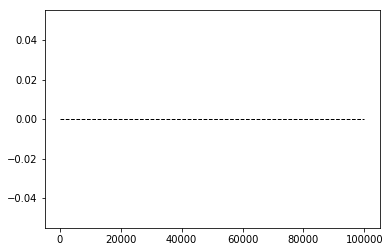

In [37]:
make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list=[0, 4, 10, 1e2, 1e3, 1e5])

In [44]:
def accuracy(coefficients,feature_matrix,sentiment):
    scores = np.dot(feature_matrix, coefficients)
    boundry = lambda x: 1 if x>0 else -1 
    vfunc = np.vectorize(boundry)
    predict = vfunc(scores)
    correct_predict = (predict == sentiment).sum()
    accuracy = correct_predict/len(feature_matrix)
    return accuracy
    

In [45]:
accuracy_table = pd.DataFrame({'accuracy': ['train','test']})
def add_accuracy_to_table(accuray, column_name):
    print(accuray)
    accuracy_table[column_name] = accuracy
    return accuracy_table

In [46]:
accuracy_0_train = accuracy(coefficients_0_penalty,feature_matrix_train, sentiment_train)
accuracy_4_train = accuracy(coefficients_4_penalty, feature_matrix_train, sentiment_train)
accuracy_10_train = accuracy(coefficients_10_penalty, feature_matrix_train, sentiment_train)
accuracy_1e2_train = accuracy(coefficients_1e2_penalty, feature_matrix_train, sentiment_train)
accuracy_1e3_train = accuracy(coefficients_1e3_penalty, feature_matrix_train, sentiment_train)
accuracy_1e5_train = accuracy(coefficients_1e5_penalty, feature_matrix_train, sentiment_train)

accuracy_0_valid = accuracy(coefficients_0_penalty,feature_matrix_valid, sentiment_valid)
accuracy_4_valid = accuracy(coefficients_4_penalty, feature_matrix_valid, sentiment_valid)
accuracy_10_valid = accuracy(coefficients_10_penalty, feature_matrix_valid, sentiment_valid)
accuracy_1e2_valid = accuracy(coefficients_1e2_penalty, feature_matrix_valid, sentiment_valid)
accuracy_1e3_valid = accuracy(coefficients_1e3_penalty, feature_matrix_valid, sentiment_valid)
accuracy_1e5_valid = accuracy(coefficients_1e5_penalty, feature_matrix_valid, sentiment_valid)


In [47]:
accuracy_data = pd.DataFrame(columns=['Coefficient','Train Accuracy', 'Test Accuracy'])

In [48]:
accuracy_data = accuracy_data.append({'Coefficient':'coefficients [L2=0]','Train Accuracy':accuracy_0_train, 'Test Accuracy': accuracy_0_valid}, ignore_index=True)
accuracy_data = accuracy_data.append({'Coefficient':'coefficients [L2=4]','Train Accuracy':accuracy_4_train, 'Test Accuracy': accuracy_4_valid}, ignore_index=True)
accuracy_data = accuracy_data.append({'Coefficient':'coefficients [L2=10]','Train Accuracy':accuracy_10_train, 'Test Accuracy': accuracy_10_valid}, ignore_index=True)
accuracy_data = accuracy_data.append({'Coefficient':'coefficients [L2=1e2]','Train Accuracy':accuracy_1e2_train, 'Test Accuracy': accuracy_1e2_valid}, ignore_index=True)
accuracy_data = accuracy_data.append({'Coefficient':'coefficients [L2=1e3]','Train Accuracy':accuracy_1e3_train, 'Test Accuracy': accuracy_1e3_valid}, ignore_index=True)
accuracy_data = accuracy_data.append({'Coefficient':'coefficients [L2=1e5]','Train Accuracy':accuracy_1e5_train, 'Test Accuracy': accuracy_1e5_valid}, ignore_index=True)

In [49]:
accuracy_data

,Coefficient,Train Accuracy,Test Accuracy
0,coefficients [L2=0],0.784653,0.782289
1,coefficients [L2=4],0.785289,0.782854
2,coefficients [L2=10],0.785830,0.783702
3,coefficients [L2=1e2],0.784276,0.782007
4,coefficients [L2=1e3],0.663565,0.662647
5,coefficients [L2=1e5],0.500813,0.499482


In [50]:
len(feature_matrix_train)

42457